In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import imagedataextractor as ide
# import other things
import cv2
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [6]:
im_path = './example-image.png'
device = 'cpu'

data = ide.extract(im_path, 
                   seg_bayesian=True,  # Bayesian mode
                   seg_tu=0.0125,  # uncertainty threshold beyond which to filter FPs
                   seg_n_samples=50,  # number of monte carlo samples for Bayesian inference
                   seg_device='cpu'  # set to 'cuda' to utilise GPU.
                  )

2021-04-14 09:56:04,768 : INFO : Input is an image of type png.
2021-04-14 09:56:06,095 : INFO : Scalebar detection successful.
2021-04-14 09:56:21,878 : INFO : Particle segmentation successful.
2021-04-14 09:56:23,140 : INFO : Extraction successful - Found 306 particles.


In [7]:
image = cv2.imread(im_path)

In [8]:
# segmentation

seg = data.segmentation.astype(float)
# from imagedataextractor.utils import shuffle_segmap
# seg = shuffle_segmap(seg)
seg[seg == 0] = np.nan  # for visualization purposes
uncertainty = data.uncertainty

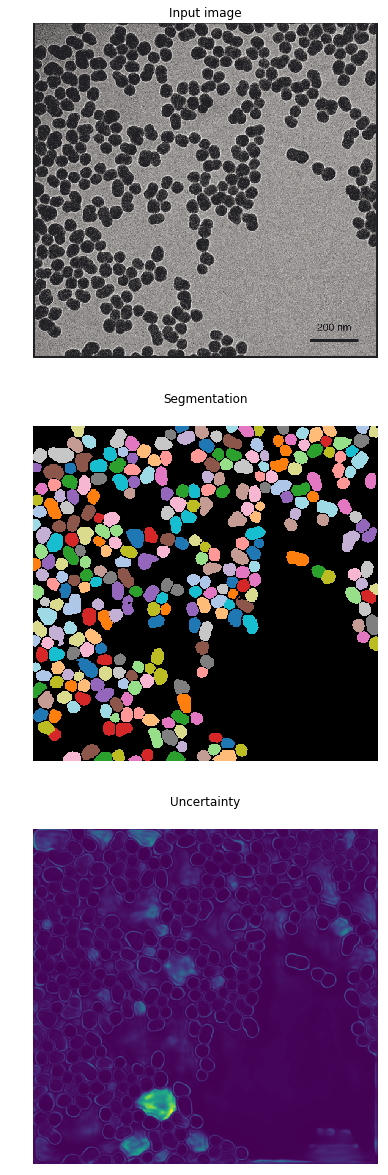

In [9]:
# visualize segmentation an uncertainty

seg_cmap = copy.copy(matplotlib.cm.tab20)
seg_cmap.set_bad(color='k')

fig, axes = plt.subplots(3, 1, figsize=(7, 21))
for ax in axes:
    ax.axis('off')
axes[0].set_title('Input image')
axes[0].imshow(image)
axes[1].set_title('Segmentation')
axes[1].matshow(seg, cmap=seg_cmap)
axes[2].set_title('Uncertainty')
axes[2].matshow(uncertainty)
plt.show()

#### Scalebar

Let's look at the scalebar extraction results.

In [10]:
# scalebar conversion

sb_text = data.scalebar.text
conversion = data.scalebar.conversion

sb_text, conversion

('200 nm', 1.5584415584415584e-09)

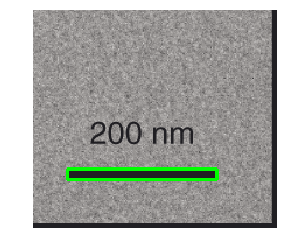

In [11]:
sb_image = cv2.drawContours(image, [data.scalebar.scalebar_contour], 0, (0, 255, 0), 2)

plt.imshow(sb_image[700:, 700:])
plt.axis('off')
plt.show()

It looks like the scalebar was read and measured correctly.

#### Extracted Data

Let's view the data as a pandas `DataFrame`.

In [12]:
df = data.to_pandas()
df.head()

,idx,center,edge,contours,area (pixels^2),area,area_units,aspect_ratio,shape_estimate,diameter,diameter_units,original_units,uncertainty
0,1,"[311, 391]",False,"[[[[382 295]], [[381 296]], [[378 296]], [[378...",966,2.346163e-15,meters^2,1.088235,None,NaN,meters,nm,0.002108
1,2,"[518, 324]",False,"[[[[330 502]], [[330 503]], [[329 504]], [[323...",1111,2.698330e-15,meters^2,1.333333,None,NaN,meters,nm,0.002899
2,3,"[54, 457]",False,"[[[[458 36]], [[458 37]], [[457 38]], [[446...",1160,2.817339e-15,meters^2,1.105263,None,NaN,meters,nm,0.002745
3,4,"[296, 270]",False,"[[[[257 274]], [[256 275]], [[252 275]], [[252...",1861,4.519885e-15,meters^2,0.923077,None,NaN,meters,nm,0.002688
4,5,"[436, 84]",False,"[[[[ 83 418]], [[ 82 419]], [[ 78 419]], [[ 78...",931,2.261157e-15,meters^2,0.769231,None,NaN,meters,nm,0.003662


#### Particle Sizes

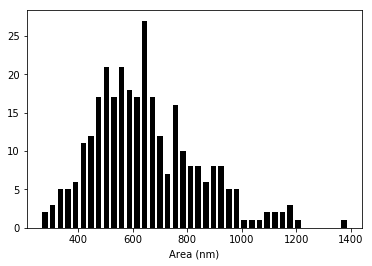

In [13]:
sizes = df['area (pixels^2)'].to_numpy() # These are in units of pixels^2.

# Let's use our scalebar conversion to convert to nanometers.
sizes = sizes / conversion  # to meters
sizes = sizes * 1e-9  # to nanometers

plt.hist(sizes, bins=40, color='k', rwidth=0.7)
plt.xlabel('Area (nm)')
plt.show()

In [14]:
print('Average particle size: {:.3f} nm    std deviation: {:.3f} nm'.format(np.mean(sizes), np.std(sizes)))

Average particle size: 647.872 nm    std deviation: 192.594 nm


#### Particle Coordinates

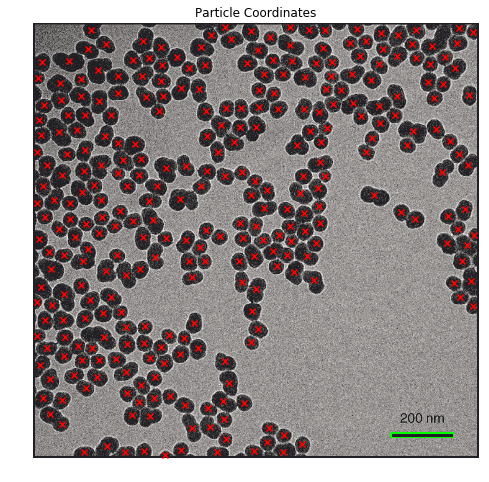

In [15]:
coords = data.coords

plt.figure(figsize=(8, 8))
plt.title('Particle Coordinates')
plt.imshow(image)
plt.scatter(coords[:, 1], coords[:, 0], marker='x', color='r')
plt.axis('off')
plt.show()

We can obtain particle coordinates from the `center` column of the pandas DataFrame. However, if we intend to use the coords to compute a radial distribution function (RDF), we don't want the coords of particles which are touching the edge of the image, as these can bias the RDF. We can use `data.valid_coords` to obtain only the coordinates of valid particles (those that don't exist on the edge).

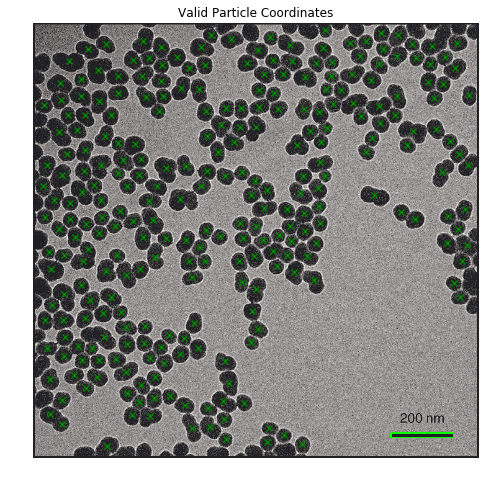

In [16]:
valid_coords = data.valid_coords

plt.figure(figsize=(8, 8))
plt.title('Valid Particle Coordinates')
plt.imshow(image)
plt.scatter(valid_coords[:, 1], valid_coords[:, 0], marker='x', color='green')
plt.axis('off')
plt.show()

#### Radial Distribution Function

#### Method 1: Using imagedataextractor

We can compute the radial distribution function using the `compute_rdf()` method of the `EMData` object.

In [17]:
dr = 5  # set our step size to 5 nm
g_r, radii = data.compute_rdf(dr=dr)

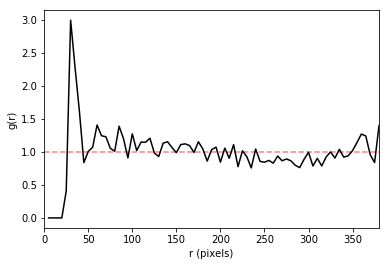

In [18]:
# visualize RDF

plt.plot(radii, g_r, color='k')
plt.hlines(1.0, 0.0, radii.max(), color='r', linestyle='--', alpha=0.5)
plt.xlim(0.0, radii.max())
plt.xlabel('r (pixels)')
plt.ylabel('g(r)')
plt.show()

#### Method 2: Using rdfpy

In [19]:
from imagedataextractor.analysis import rdf2d

# Let's use our scalebar conversion to convert to nanometers.
valid_coords = valid_coords / conversion  # to meters
valid_coords = valid_coords * 1e-9  # to nanometers

dr = 2.5  # nm

g_r, radii = rdf2d(valid_coords, dr=dr)

This method is more flexible, as we can convert the coords to nanometers if we wish. We should obtain the same result as before.

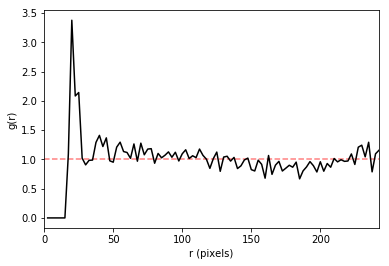

In [20]:
# visualize RDF

plt.plot(radii, g_r, color='k')
plt.hlines(1.0, 0.0, radii.max(), color='r', linestyle='--', alpha=0.5)
plt.xlim(0.0, radii.max())
plt.xlabel('r (pixels)')
plt.ylabel('g(r)')
plt.show()